## Imports and Definitions

In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import scipy as sp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
hetvips_lamost = Table.read('hetvips_lamost.fits', format = 'fits')

In [3]:
# creating wavelength grid
wave_len = len(hetvips_lamost['spec'][0])
wave_arr = np.linspace(3470,5540,wave_len)
print(wave_len,len(wave_arr))

1036 1036


In [4]:
hetvips_lamost

objID_1,RA,Dec,shotid,gmag,rmag,imag,zmag,ymag,sn,barycor,mjd,exptime,chi2_star,chi2_galaxy,chi2_qso,z_star,z_galaxy,z_qso,z_best,classification,stellartype,ObjID_2,filename_1,index_in_file,spec,spec_error,spec_weight,RV_1,barycorr,SPECID_1,RA_1,DEC_1,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV_2,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME_2,specid_2,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,Separation_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),'dex',deg,deg,deg,deg,,arcsec,arcsec
bytes16,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes1,bytes16,bytes58,int64,float64[1036],float64[1036],float64[1036],float64,float64,bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,

## Interpolating

In [5]:
example = hetvips_lamost['spec'][0]

# filling masked indices with nans
nan_spec = example.filled(np.nan)

Text(0, 0.5, 'Flux')

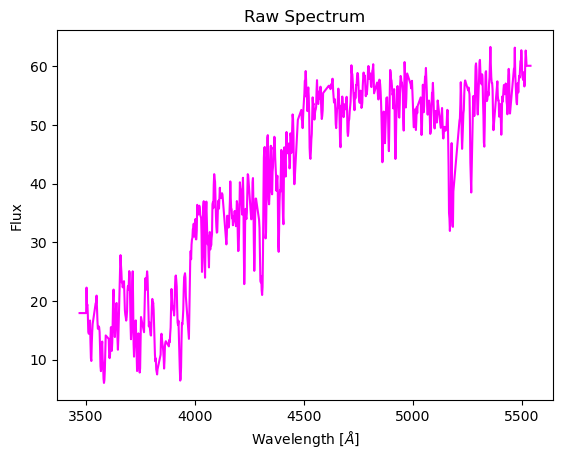

In [167]:
plt.title('Raw Spectrum')
plt.plot(wave_arr,nan_spec,color='magenta')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [7]:
# filling the nans
nan_indices = np.isnan(nan_spec)
x_len = np.arange(len(nan_spec))

# defining what will be interpolated
x = x_len[nan_indices]
xp = x_len[~nan_indices]
fp = nan_spec[~nan_indices]

interp_values = np.interp(x, xp, fp)
resampled_spec = nan_spec
resampled_spec[nan_indices] = interp_values

Text(0, 0.5, 'Flux')

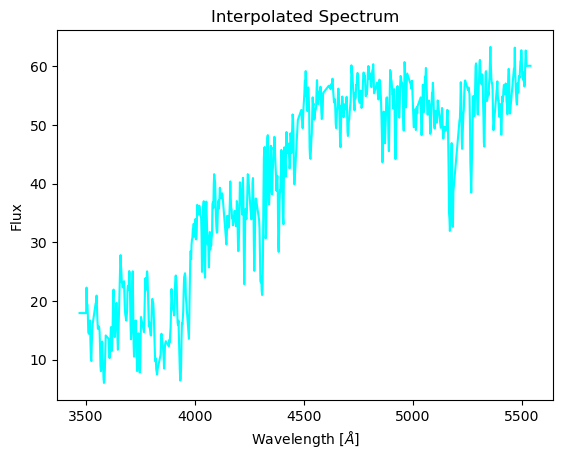

In [168]:
plt.title('Interpolated Spectrum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [130]:
# creating general definition
def interpolation(spectrum):
    # defining masked indices as nans
    nan_spec = spectrum.filled(np.nan)
    
    # filling the nans
    nan_indices = np.isnan(nan_spec)

    # defining what will be interpolated
    x_len = np.arange(len(nan_spec))
    x = x_len[nan_indices]
    xp = x_len[~nan_indices]
    fp = nan_spec[~nan_indices]

    # interpolating
    interp_values = np.interp(x, xp, fp)
    resampled_spec = nan_spec
    resampled_spec[nan_indices] = interp_values

    return resampled_spec

## Continuum Normalizing

In [71]:
slice = 100
half_slice = slice//2
cont_arr = []

for i in range(half_slice, len(resampled_spec) + half_slice):
    sliced_spec = resampled_spec[i-half_slice:i+half_slice]
    cont = np.percentile(sliced_spec, 90)
    cont_arr.append(cont)
    slice = slice + 1

Text(0, 0.5, 'Flux')

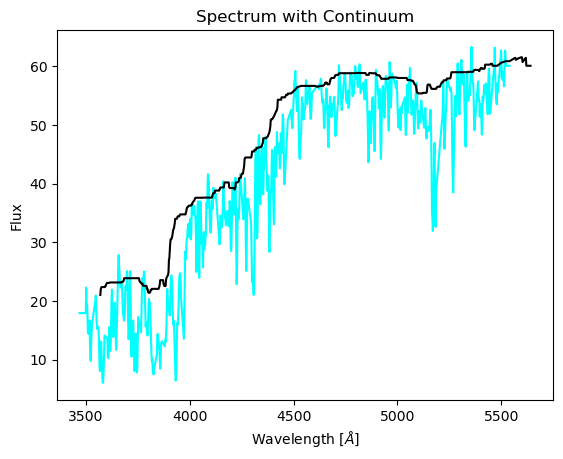

In [169]:
plt.title('Spectrum with Continuum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.plot(wave_arr+100,cont_arr,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [170]:
# interpolating the first ~100 Ang of continuum, will cut off edges later
nan_arr = np.full(100, np.nan)
continuum = np.concatenate((nan_arr,cont_arr))

# filling the nans
nan_indices = np.isnan(continuum)
x_len = np.arange(len(continuum))

# defining what will be interpolated
x = x_len[nan_indices]
xp = x_len[~nan_indices]
fp = continuum[~nan_indices]

interp_values = np.interp(x, xp, fp)
continuum[nan_indices] = interp_values
continuum = continuum[:-100]

Text(0, 0.5, 'Flux')

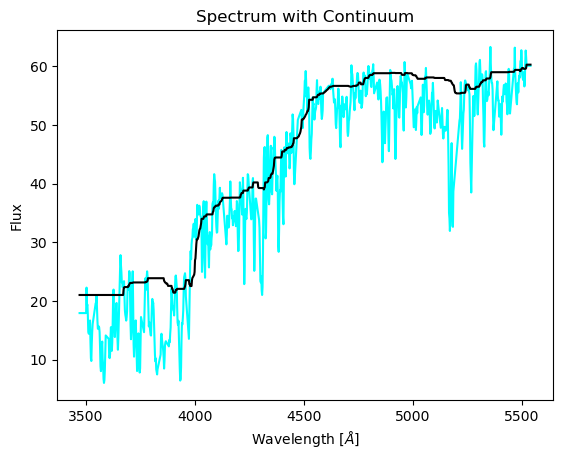

In [172]:
plt.title('Spectrum with Continuum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.plot(wave_arr,continuum,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [173]:
normalized_spec = resampled_spec / continuum

Text(0, 0.5, 'Normalized Flux')

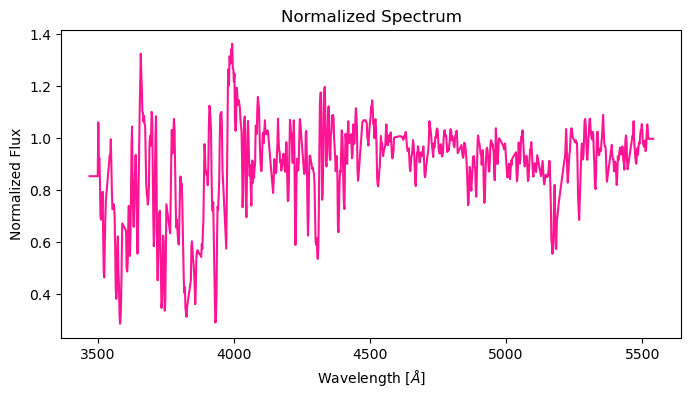

In [213]:
plt.figure(figsize=(8,4))
plt.title('Normalized Spectrum')
plt.plot(wave_arr,normalized_spec,color='deeppink')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')

In [179]:
# creating general definition
def normalization(spectrum,percent):

    slice = 100
    half_slice = slice//2
    cont_arr = []

    for i in range(half_slice, len(spectrum) + half_slice):
        sliced_spec = spectrum[i-half_slice:i+half_slice]
        cont = np.percentile(sliced_spec, 90)
        cont_arr.append(cont)
        slice = slice + 1

    # interpolating the first ~100 Ang of continuum, will cut off edges later
    nan_arr = np.full(100, np.nan)
    continuum = np.concatenate((nan_arr,cont_arr))

    nan_indices = np.isnan(continuum)
    x_len = np.arange(len(continuum))

    x = x_len[nan_indices]
    xp = x_len[~nan_indices]
    fp = continuum[~nan_indices]

    interp_values = np.interp(x, xp, fp)
    continuum[nan_indices] = interp_values
    continuum = continuum[:-100]
    
    normalized_spec = spectrum / continuum
    
    return continuum,  normalized_spec

## Applying Interpolations and Normalizations to all Science Spectra

In [202]:
# making a generalized definition
def interp_norm(table,spec_array,percent):
    spec_l = []
    
    for i in range(len(table)):
        s = interpolation(table[spec_array][i])
        spec_l.append(s)

    table['smooth_spec'] = spec_l

    cont_l = []
    norm_l = []

    for i in range(len(table)):
        c , n = normalization(table['smooth_spec'][i],percent)
        cont_l.append(c)
        norm_l.append(n)

    table['continuum'] = cont_l
    table['normalized_spec'] = norm_l

In [180]:
interp_norm(hetvips_lamost,'spec',95)

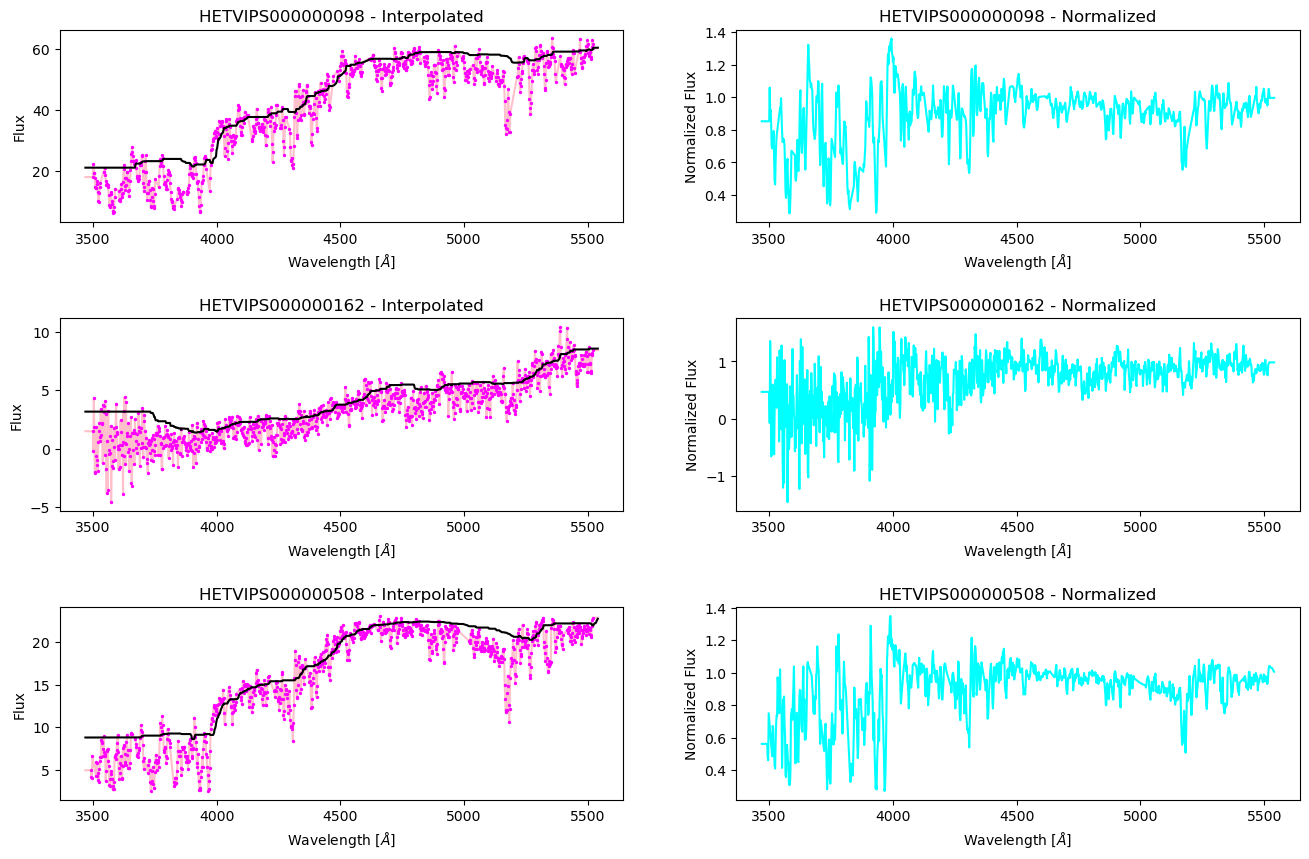

In [184]:
# plotting the first couple of spectra 
fig,ax = plt.subplots(3,2,dpi=100,figsize=(16,10), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
for i in range(0,3):
    ax[i][0].plot(wave_arr,hetvips_lamost['smooth_spec'][i],color='pink',zorder=1)
    ax[i][0].scatter(wave_arr,hetvips_lamost['spec'][i],s=2,color='magenta')
    ax[i][0].plot(wave_arr,hetvips_lamost['continuum'][i],color='black')
    ax[i][1].plot(wave_arr,hetvips_lamost['normalized_spec'][i],color='cyan')

    ax[i][1].set_title('%s - Normalized'%(hetvips_lamost['objID_1'][i]))
    ax[i][1].set_xlabel(r'Wavelength [$\AA$]')
    ax[i][1].set_ylabel('Normalized Flux')
    ax[i][0].set_title('%s - Interpolated'%(hetvips_lamost['objID_1'][i]))
    ax[i][0].set_xlabel(r'Wavelength [$\AA$]')
    ax[i][0].set_ylabel('Flux')

In [190]:
# saving table as a file so we don't have to re-run it each time
# hetvips_lamost.write('hetvips_normalized_lamost.ecsv',format='ascii')

## Matching Template Spectra

In [193]:
# trying with one template first
template = Table.read('../RVgrid/T4000_g0.50_f-0.50.spec.conv',format='ascii',names=['wave','flux_n','flux_u'])

In [205]:
# defining what will be interpolated
x = wave_arr
xp = np.arange(len(template))
fp = template['flux_u']

# interp_temp = np.interp(x, xp, fp)
interp_temp = np.interp(x,template['wave'],template['flux_u'])
cont_temp, norm_temp = normalization(interp_temp,95)

Text(0, 0.5, 'Flux')

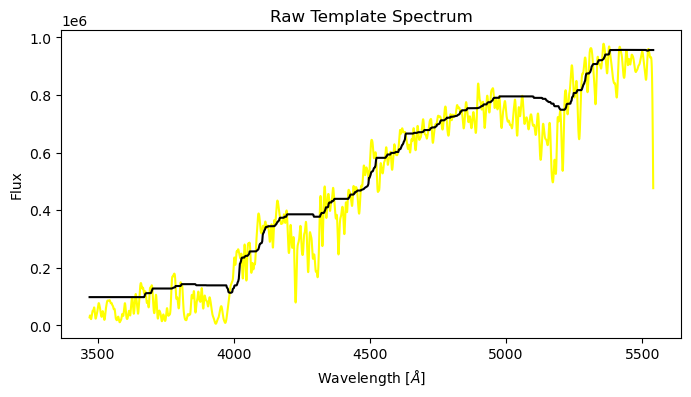

In [211]:
plt.figure(figsize=(8,4))
plt.title('Raw Template Spectrum')
plt.plot(template['wave'],template['flux_u'],color='yellow')
plt.plot(wave_arr,cont_temp,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

Text(0, 0.5, 'Normalized Flux')

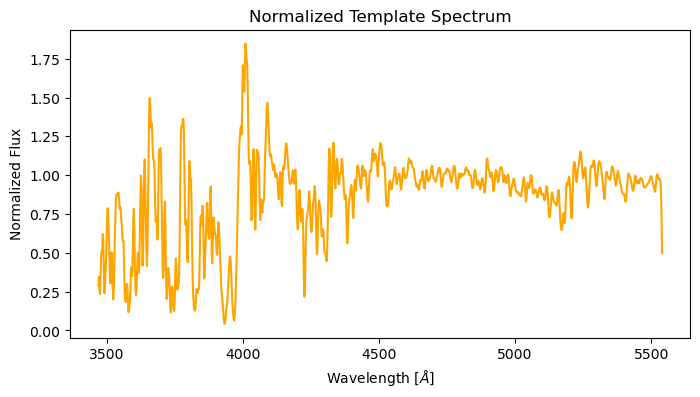

In [212]:
plt.figure(figsize=(8,4))
plt.title('Normalized Template Spectrum')
plt.plot(wave_arr,norm_temp,color='orange')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')

In [ ]:
# doing for all template spectra


## Computing Chi2
#### Chi2 equation is $\Sigma(F_{obs} - F_{temp})^2$ / $\sigma_{obs err}^2$